# Setup

In [21]:
%matplotlib ipympl
from itertools import chain

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely.geometry

mpl.rcParams["figure.dpi"] = 100
import seaborn as sns

sns.set()

import shapely
import momepy
import networkx as nx

from src.space.utils import segmented
from src.space.road_network import RoadNetwork

# UB Walkway

In [22]:
ub_walkway = gpd.read_file("../data/raw/ub/UB_walkway_line.shp")
ub_walkway.drop("Id", axis=1, inplace=True)
ub_walkway.index.name = "unique_id"
ub_walkway["num_points"] = ub_walkway.apply(
    lambda row: len(row["geometry"].coords), axis=1
)

print(f"ub_walkway.shape: {ub_walkway.shape}")
ub_walkway.head()

ub_walkway.shape: (277, 2)


,geometry,num_points
unique_id,,
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",53
1,"LINESTRING (-78.78682 43.00841, -78.78675 43.0...",2
2,"LINESTRING (-78.78749 43.00956, -78.78733 43.0...",9
3,"LINESTRING (-78.78732 43.00908, -78.78736 43.0...",4
4,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",74


### Walkway Vertices

total number of road vertices: 1565


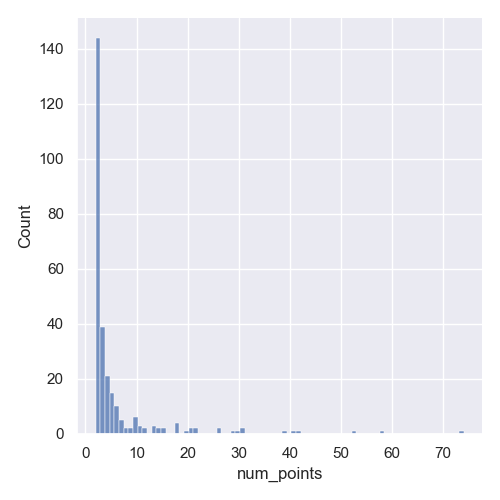

In [23]:
print(f"total number of road vertices: {ub_walkway['num_points'].sum()}")

sns.displot(x="num_points", data=ub_walkway, kind="hist")

In [24]:
points_df = pd.Series(
    list(
        chain.from_iterable(
            ub_walkway.apply(lambda line: [p for p in line["geometry"].coords], axis=1)
        )
    )
).to_frame()

print(f"points_df.shape: {points_df.shape}")
points_df.head()

points_df.shape: (1565, 1)


,0
0,"(-78.78607950162117, 43.00990081100238)"
1,"(-78.7862343806616, 43.009900277753545)"
2,"(-78.78689293143123, 43.00990560784922)"
3,"(-78.78702412978768, 43.00988642045962)"
4,"(-78.78713152770352, 43.00984550270828)"


In [25]:
points_count_df = (
    points_df.value_counts()
    .to_frame()
    .rename(columns={0: "count"})
    .reset_index()
    .rename(columns={0: "coord"})
)
ub_walkway_vertices = gpd.GeoDataFrame(
    points_count_df,
    geometry=points_count_df["coord"].apply(lambda p: shapely.geometry.Point(p)),
)
ub_walkway_vertices.drop("coord", axis=1, inplace=True)
print(f"ub_walkway_vertices.shape: {ub_walkway_vertices.shape}")
ub_walkway_vertices.head()

ub_walkway_vertices.shape: (1236, 2)


,count,geometry
0,6,POINT (-78.79251 43.00018)
1,4,POINT (-78.78988 43.00147)
2,4,POINT (-78.79515 42.99933)
3,3,POINT (-78.78672 42.99749)
4,3,POINT (-78.77628 43.00225)


<Axes: >

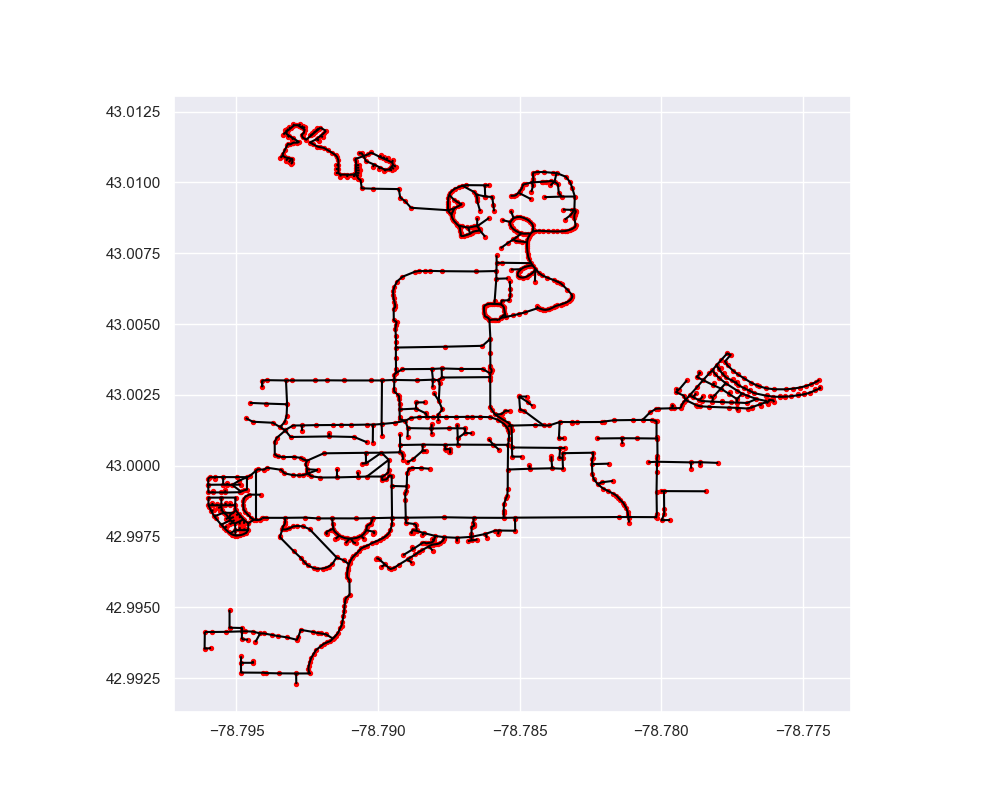

In [26]:
ax = ub_walkway.plot(figsize=(10, 8), color="black")
ub_walkway_vertices.plot(ax=ax, markersize=8, color="red", marker="o")

# Convert from GeoDataFrame to Graph

Reference: [Converting from GeoDataFrame to Graph and back](http://docs.momepy.org/en/stable/user_guide/graph/convert.html)

## UB Walkway

In [27]:
ub_walkway.head()

,geometry,num_points
unique_id,,
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",53
1,"LINESTRING (-78.78682 43.00841, -78.78675 43.0...",2
2,"LINESTRING (-78.78749 43.00956, -78.78733 43.0...",9
3,"LINESTRING (-78.78732 43.00908, -78.78736 43.0...",4
4,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",74


In [28]:
ub_walkway_segmented = gpd.GeoDataFrame(geometry=segmented(ub_walkway["geometry"]))
ub_walkway_segmented["length"] = ub_walkway_segmented.length
print(f"ub_walkway_segmented.shape: {ub_walkway_segmented.shape}")
ub_walkway_segmented.head()

ub_walkway_segmented.shape: (1279, 2)


,geometry,length
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",0.000155
1,"LINESTRING (-78.78623 43.00990, -78.78689 43.0...",0.000659
2,"LINESTRING (-78.78689 43.00991, -78.78702 43.0...",0.000133
3,"LINESTRING (-78.78702 43.00989, -78.78713 43.0...",0.000115
4,"LINESTRING (-78.78713 43.00985, -78.78730 43.0...",0.000178


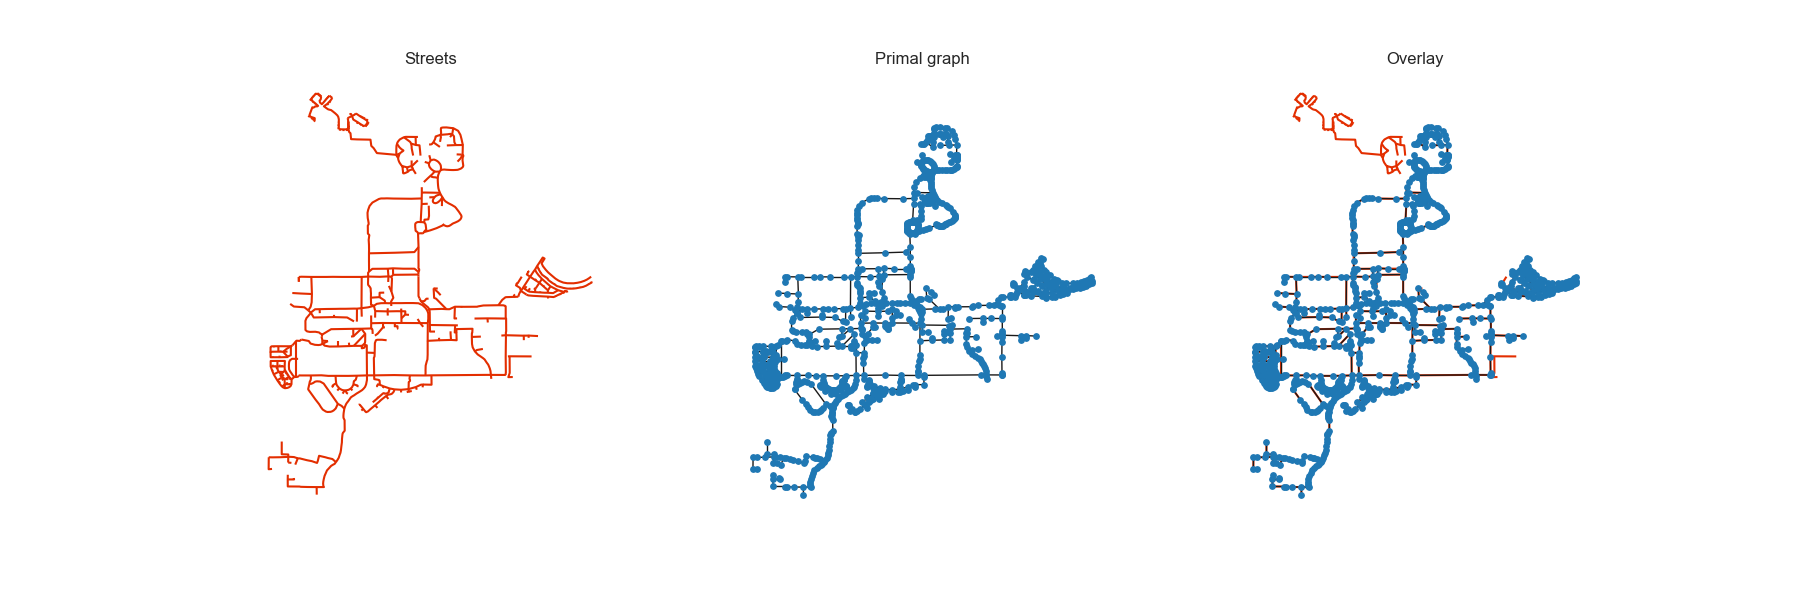

In [29]:
ub_walkway_network = RoadNetwork(lines=ub_walkway["geometry"])

f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")

ub_walkway.plot(color="#e32e00", ax=ax[0])
nx.draw(
    ub_walkway_network.nx_graph,
    {n: [n[0], n[1]] for n in list(ub_walkway_network.nx_graph.nodes)},
    ax=ax[1],
    node_size=15,
)
ub_walkway.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    ub_walkway_network.nx_graph,
    {n: [n[0], n[1]] for n in list(ub_walkway_network.nx_graph.nodes)},
    ax=ax[2],
    node_size=15,
)

<Axes: >

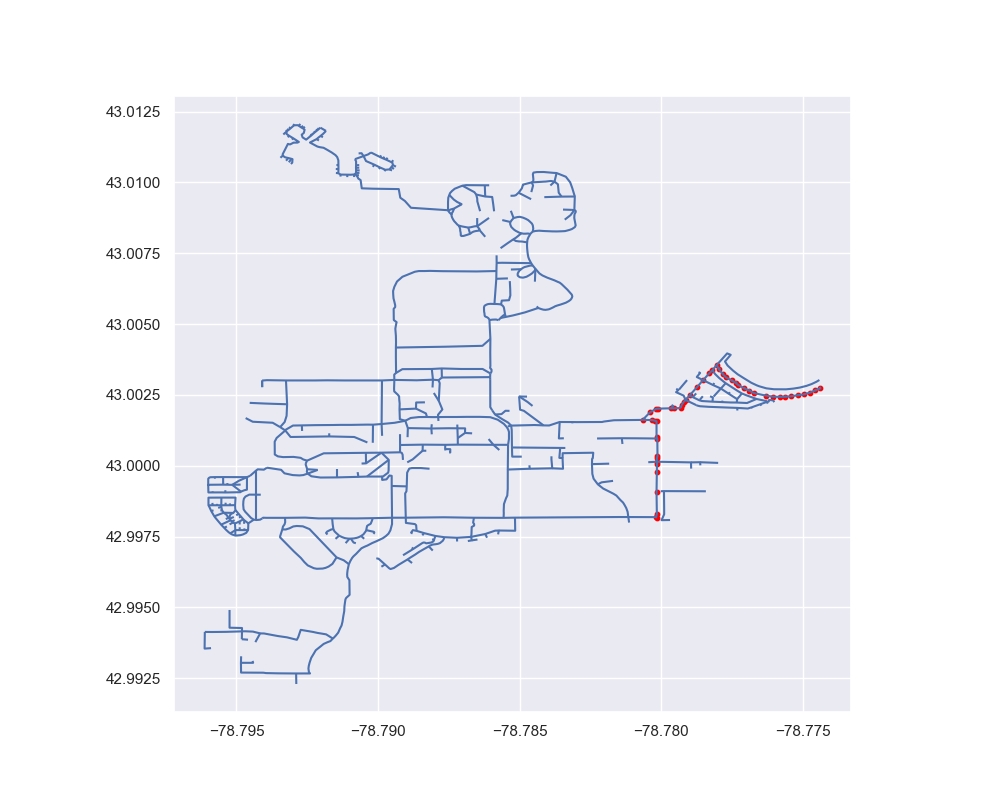

In [30]:
from shapely.geometry import Point

path = ub_walkway_network.get_shortest_path((-78, 43), (-78, 42))
path_gdf = gpd.GeoDataFrame(geometry=[Point(p) for p in path])

ax = ub_walkway.plot(figsize=(10, 8))
path_gdf.plot(marker="o", color="red", markersize=10, ax=ax)

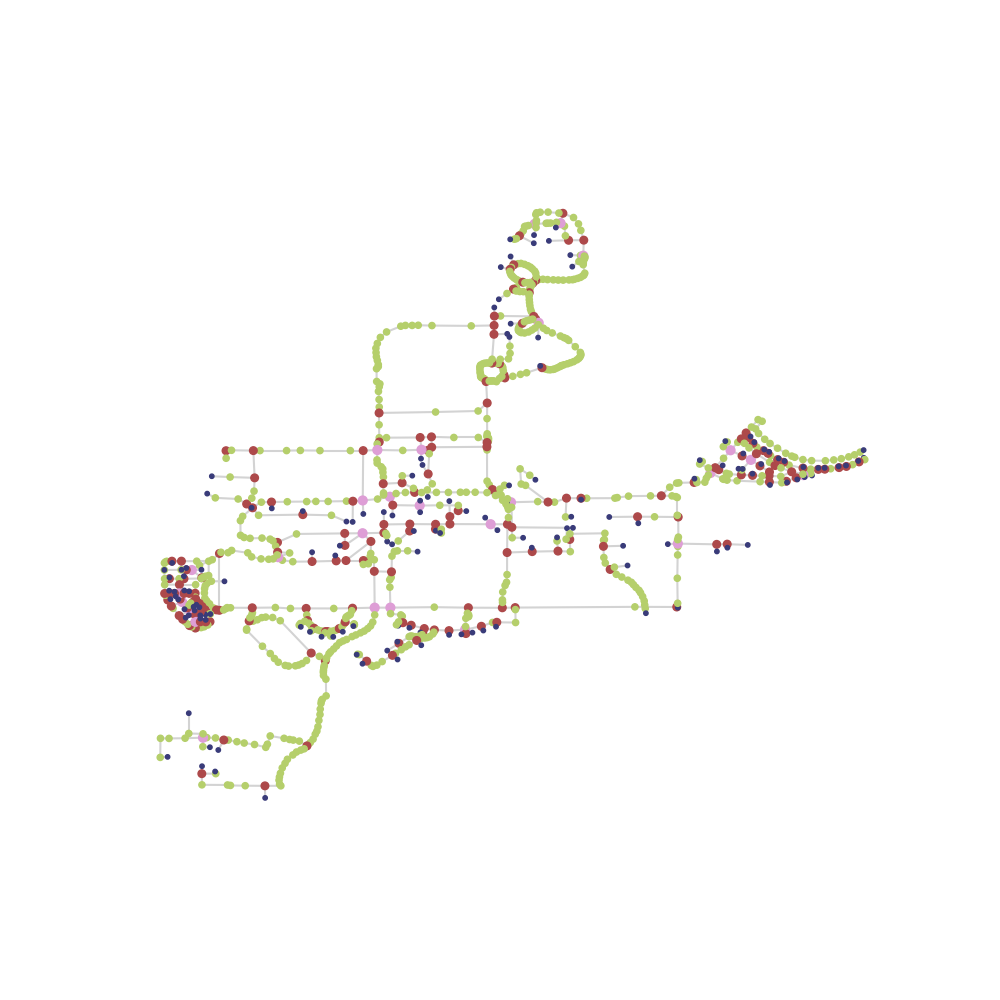

In [31]:
degree = dict(nx.degree(ub_walkway_network.nx_graph))
nx.set_node_attributes(ub_walkway_network.nx_graph, degree, "degree")

graph = momepy.node_degree(ub_walkway_network.nx_graph, name="degree")

nodes, edges, sw = momepy.nx_to_gdf(
    graph, points=True, lines=True, spatial_weights=True
)

f, ax = plt.subplots(figsize=(10, 10))
nodes.plot(
    ax=ax, column="degree", cmap="tab20b", markersize=(nodes["degree"] * 10), zorder=2
)
edges.plot(ax=ax, color="lightgrey", zorder=1)
ax.set_axis_off()
plt.show()

In [32]:
print(f"nodes.shape: {nodes.shape}")
nodes.head()

nodes.shape: (1002, 3)


,degree,nodeID,geometry
0,2,0,POINT (-78.78316 43.00903)
1,4,1,POINT (-78.78307 43.00902)
2,2,2,POINT (-78.78304 43.00901)
3,2,3,POINT (-78.78303 43.00899)
4,2,4,POINT (-78.78302 43.00896)


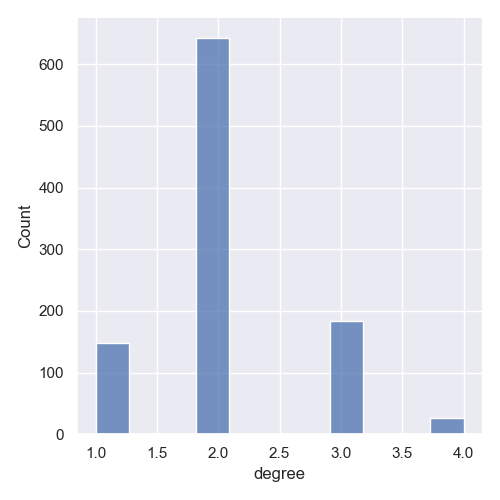

In [33]:
sns.displot(x="degree", data=nodes)

In [34]:
print(f"edges.shape: {edges.shape}")
edges.head()

edges.shape: (1047, 4)


,geometry,length,node_start,node_end
0,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",0.000086,0,1
1,"LINESTRING (-78.78316 43.00903, -78.78347 43.0...",0.000314,0,412
2,"LINESTRING (-78.78307 43.00902, -78.78304 43.0...",0.000033,1,2
3,"LINESTRING (-78.78307 43.00902, -78.78321 43.0...",0.000223,1,560
4,"LINESTRING (-78.78307 43.00902, -78.78306 43.0...",0.000480,1,862


## GMU Walkway (updated data)

In [35]:
gmu_walkway_updated = gpd.read_file("../data/raw/gmu/Mason_walkway_line.shp")
gmu_walkway_updated.index.name = "unique_id"
gmu_walkway_updated["num_points"] = gmu_walkway_updated.apply(
    lambda row: len(row["geometry"].coords), axis=1
)

print(f"gmu_walkway_updated.shape: {gmu_walkway_updated.shape}")
gmu_walkway_updated.head()

gmu_walkway_updated.shape: (1092, 8)


,ENABLED,SURFACE,WALK_TYPE,EMERG_SEC,ADA_TYPE,SHAPE_LENG,geometry,num_points
unique_id,,,,,,,,
0,1,P,1,6.034048,0,44.250861,"LINESTRING (11822243.673 6987633.950, 11822282...",2
1,1,P,1,6.370360,0,46.717215,"LINESTRING (11822259.353 6987602.921, 11822300...",2
2,1,P,0,99999.000000,1,34.496568,"LINESTRING (11822282.498 6987655.182, 11822300...",2
3,1,P,1,7.746703,1,56.810669,"LINESTRING (11822300.208 6987625.579, 11822350...",2
4,1,P,0,99999.000000,1,107.644324,"LINESTRING (11822348.743 6987532.180, 11822399...",2


total number of road vertices: 2786


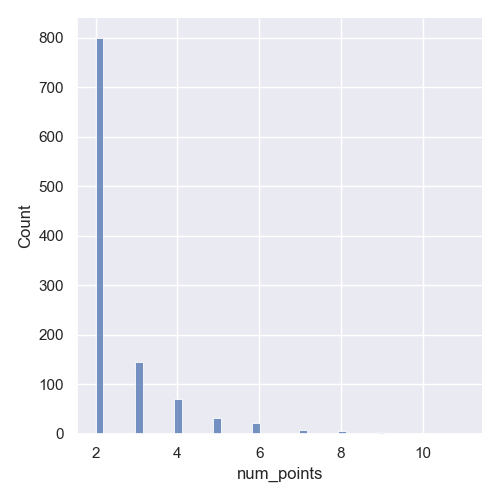

In [36]:
print(f"total number of road vertices: {gmu_walkway_updated['num_points'].sum()}")

sns.displot(x="num_points", data=gmu_walkway_updated, kind="hist")

In [37]:
gmu_walkway_updated_points_df = pd.Series(
    list(
        chain.from_iterable(
            gmu_walkway_updated.apply(
                lambda line: [p for p in line["geometry"].coords], axis=1
            )
        )
    )
).to_frame()

print(f"gmu_walkway_updated_points_df.shape: {gmu_walkway_updated_points_df.shape}")
gmu_walkway_updated_points_df.head()

gmu_walkway_updated_points_df.shape: (2786, 1)


,0
0,"(11822243.6730211, 6987633.950254902)"
1,"(11822282.497719716, 6987655.181869303)"
2,"(11822259.353018502, 6987602.921007925)"
3,"(11822300.208059575, 6987625.578540429)"
4,"(11822282.497719716, 6987655.181869303)"


In [38]:
gmu_walkway_updated_points_count_df = (
    gmu_walkway_updated_points_df.value_counts()
    .to_frame()
    .rename(columns={0: "count"})
    .reset_index()
    .rename(columns={0: "coord"})
)
gmu_walkway_updated_vertices = gpd.GeoDataFrame(
    gmu_walkway_updated_points_count_df,
    geometry=gmu_walkway_updated_points_count_df["coord"].apply(
        lambda p: shapely.geometry.Point(p)
    ),
)
gmu_walkway_updated_vertices.drop("coord", axis=1, inplace=True)
print(f"gmu_walkway_updated_vertices.shape: {gmu_walkway_updated_vertices.shape}")
gmu_walkway_updated_vertices.head()

gmu_walkway_updated_vertices.shape: (1452, 2)


,count,geometry
0,5,POINT (11821860.726 6988082.662)
1,5,POINT (11822144.850 6987517.355)
2,5,POINT (11822300.208 6987625.579)
3,5,POINT (11822300.847 6988617.756)
4,5,POINT (11822359.101 6988010.904)


<Axes: >

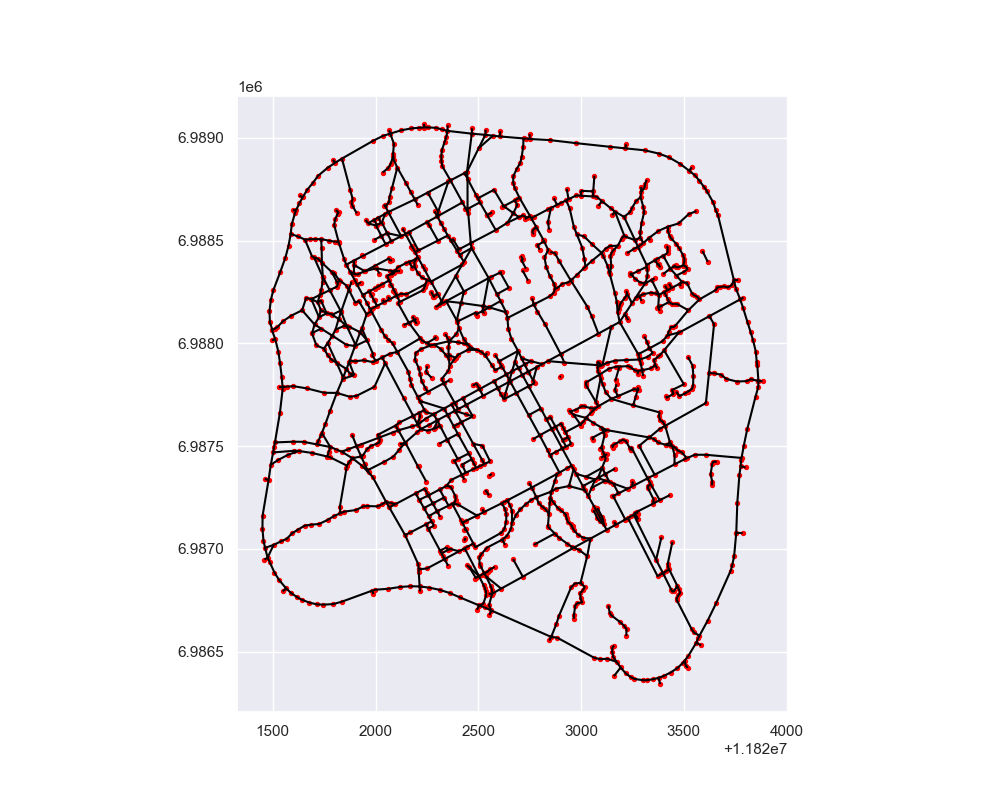

In [39]:
ax = gmu_walkway_updated.plot(figsize=(10, 8), color="black", aspect=1)
gmu_walkway_updated_vertices.plot(ax=ax, markersize=8, color="red", marker="o")

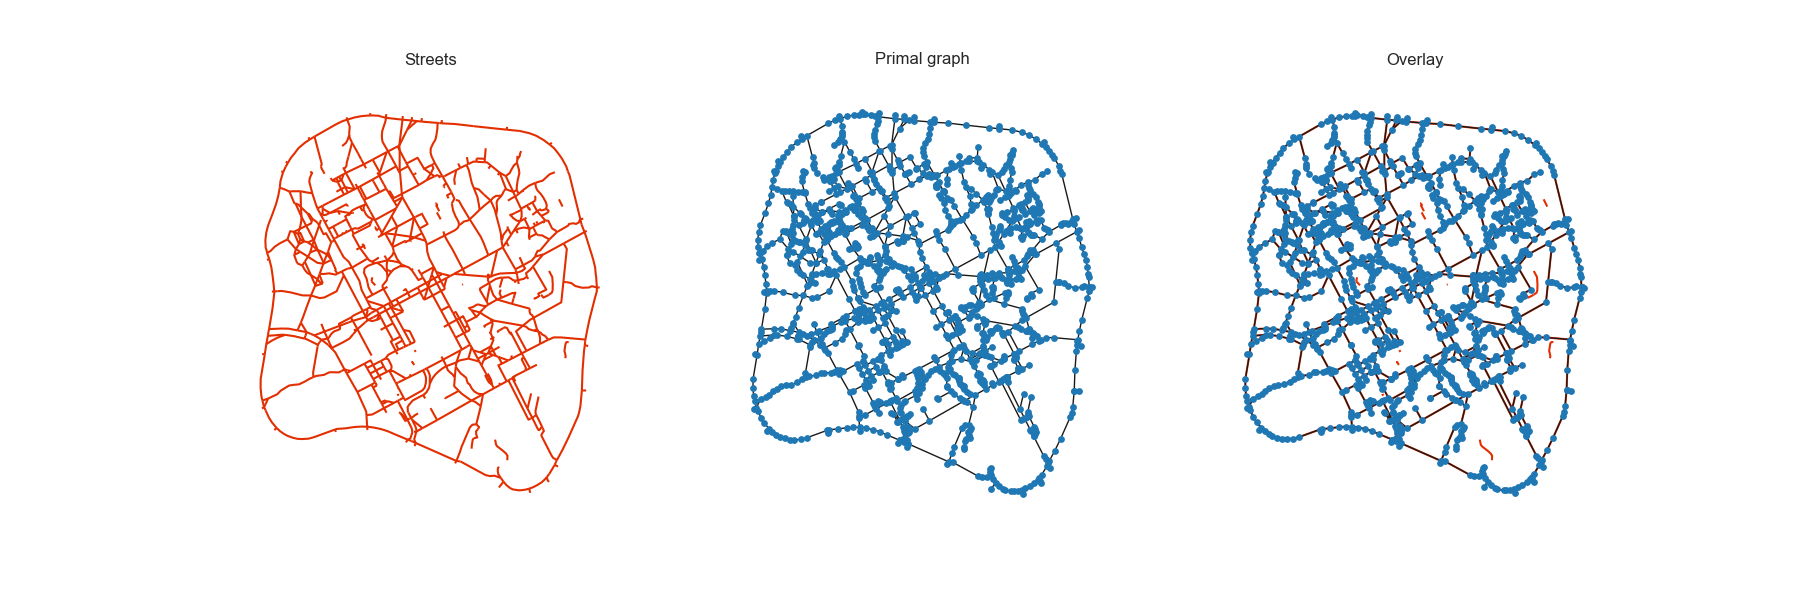

In [40]:
gmu_walkway_updated_network = RoadNetwork(lines=gmu_walkway_updated["geometry"])

f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")

gmu_walkway_updated.plot(color="#e32e00", ax=ax[0], aspect=1)
nx.draw(
    gmu_walkway_updated_network.nx_graph,
    {n: [n[0], n[1]] for n in list(gmu_walkway_updated_network.nx_graph.nodes)},
    ax=ax[1],
    node_size=15,
)
gmu_walkway_updated.plot(color="#e32e00", ax=ax[2], zorder=-1, aspect=1)
nx.draw(
    gmu_walkway_updated_network.nx_graph,
    {n: [n[0], n[1]] for n in list(gmu_walkway_updated_network.nx_graph.nodes)},
    ax=ax[2],
    node_size=15,
)